| Heading | Information |
|-|-|
| Author | Ja`Mone Bridges |
| Subject | Hadoop and Spark |
| Deliverable | Big Data Wrangling With Google Books Ngrams |



| Notebook Contents |
|-|
| [Introduction](#introduction) |
| [Report](#report) |
| [JupyterHub PySpark Notebook](#jupyterhub-pyspark-notebook)|
| [S3 Bucket Retrieval with Python](#s3-bucket-retrieval-with-python) |
| [Data Cleaning](#data-cleaning) |
| [Plot](#plot) |

## Introduction
#### I  apply the skills for Big Data Fundamentals to load, filter, and visualize a large real-world dataset in a cloud-based distributed computing environment using Hadoop, Spark, Hive, and the S3 filesystem.

## Report
[PDF Version](./Reports/Hadoop%20and%20PySpark%20Report.pdf)<br>
[Word Version](./Reports/Hadoop%20and%20PySpark%20Report.docx)

## JupyterHub PySpark Notebook
[JupyterHub PySpark Notebook](./Notebooks/Hadoop%20and%20PySpark.ipynb)

## S3 Bucket Retrieval with Python
[S3 Bucket Retrieval with Python](./Notebooks/S3%20Bucket%20Download%20with%20Python.ipynb)

In [1]:
import pandas as pd

In [2]:
eng_df = pd.read_csv('data/eng_token_data_local.csv')

## Data Cleaning

#### Sanity check to make sure the data is properly loaded into the dataframe.

In [3]:
eng_df.head()

,Unnamed: 0,token,year,frequency,pages,books
0,0,laticaudata,1800,1,1,1
1,1,laticaudata,1823,2,2,2
2,2,laticaudata,1827,1,1,1
3,3,laticaudata,1843,2,2,1
4,4,laticaudata,1844,6,6,4


#### Drop the duplicate index column.

In [4]:
eng_df.drop(columns='Unnamed: 0', inplace=True)

#### Check the shape of the dataframe.

In [5]:
display('Dataframe shape: ' + str(eng_df.shape))

'Dataframe shape: (24681, 5)'

#### Check for Null values and data types.

In [6]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24681 entries, 0 to 24680
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token      24681 non-null  object
 1   year       24681 non-null  object
 2   frequency  24681 non-null  object
 3   pages      24681 non-null  object
 4   books      24681 non-null  object
dtypes: object(5)
memory usage: 964.2+ KB


#### Custom functions for converting datatypes.

In [7]:
# Function to test if a string is a number
# Use this function for INT type as well.
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def pd_as_type(df, column, data_type, error_symbol, check_type_function):
    df[column] = df[column].apply(lambda x: error_symbol if check_type_function(x) == False else x)
    df[column] = df[column].astype(data_type)

#### Convert year, frequency, and pages to data type int using custom functions.

In [8]:
pd_as_type(eng_df, 'year', int, '-1', is_float)
pd_as_type(eng_df, 'frequency', int, '-1', is_float)
pd_as_type(eng_df, 'pages', int, '-1', is_float)

#### Sanity check after data type conversions.

In [9]:
eng_df.head()

,token,year,frequency,pages,books
0,laticaudata,1800,1,1,1
1,laticaudata,1823,2,2,2
2,laticaudata,1827,1,1,1
3,laticaudata,1843,2,2,1
4,laticaudata,1844,6,6,4


#### Verify that the columns year, frequency, and pages data type has changed to type INT.

In [10]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24681 entries, 0 to 24680
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token      24681 non-null  object
 1   year       24681 non-null  int32 
 2   frequency  24681 non-null  int32 
 3   pages      24681 non-null  int32 
 4   books      24681 non-null  object
dtypes: int32(3), object(2)
memory usage: 675.0+ KB


#### Check distribution the of data. If columns year, frequency, or pages min is -1, then those columns had some invalid strings to convert to data type INT.

In [11]:
eng_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,24681.0,1920.560836,99.474340,-1.0,1877.0,1936.0,1979.0,2008.0
frequency,24681.0,532.508772,8968.231462,-1.0,1.0,3.0,7.0,254561.0
pages,24681.0,299.699040,4648.390233,-1.0,1.0,2.0,6.0,122472.0


#### A check to of the percentage of rows with invalid conversions to data type INT.

In [12]:
display('Percentage of affected rows: ' + \
    str(((eng_df[eng_df['year'] <= 0].count() + eng_df[eng_df['frequency'] <= 0].count() + eng_df[eng_df['pages'] <= 0].count()) / eng_df.shape[0] * 100).agg('year').mean())\
    + '%')

'Percentage of affected rows: 0.4740488634982375%'

#### The number of affected rows is less than 0.5%.  It is reasonable to drop the rows instead of imputing them.

In [13]:
year_drop = eng_df[eng_df['year'] <= 0].index
eng_df.drop(year_drop, inplace=True)

freq_drop = eng_df[eng_df['frequency'] <= 0].index
eng_df.drop(freq_drop, inplace=True)

page_drop = eng_df[eng_df['pages'] <= 0].index
eng_df.drop(page_drop, inplace=True)


#### Verifying the removal of affected rows.

In [14]:
display('Percentage of affected rows: ' + \
    str(((eng_df[eng_df['year'] <= 0].count() + eng_df[eng_df['frequency'] <= 0].count() + eng_df[eng_df['pages'] <= 0].count()) / eng_df.shape[0] * 100).agg('year').mean())\
    + '%')

'Percentage of affected rows: 0.0%'

In [15]:
display('Dataframe shape: ' + str(eng_df.shape))

'Dataframe shape: (24642, 5)'

In [16]:
eng_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,24642.0,1923.602021,63.698492,1520.0,1877.0,1936.0,1979.0,2008.0
frequency,24642.0,533.353137,8975.300655,1.0,1.0,3.0,7.0,254561.0
pages,24642.0,300.174945,4652.051942,1.0,1.0,2.0,6.0,122472.0


#### Check for any duplicated rows.

In [17]:
display('Number of duplicates: ' + str(eng_df.duplicated().sum()))

'Number of duplicates: 0'

## Plot
#### I created a plot of the number of occurrences of the token "data". First, I will create a new dataframe by filtering the data from the dataset.
> ####  Note: The query for the token "data" did not take into account the case of the characters.

In [18]:
plot_eng_df = eng_df[['year', 'frequency']].groupby('year').count()
plot_eng_df

,frequency
year,
1520,1
1576,1
1584,8
1603,1
1614,1
...,...
2004,200
2005,196
2006,216


#### Plot the data in a bar graph and use log scaling for readability.

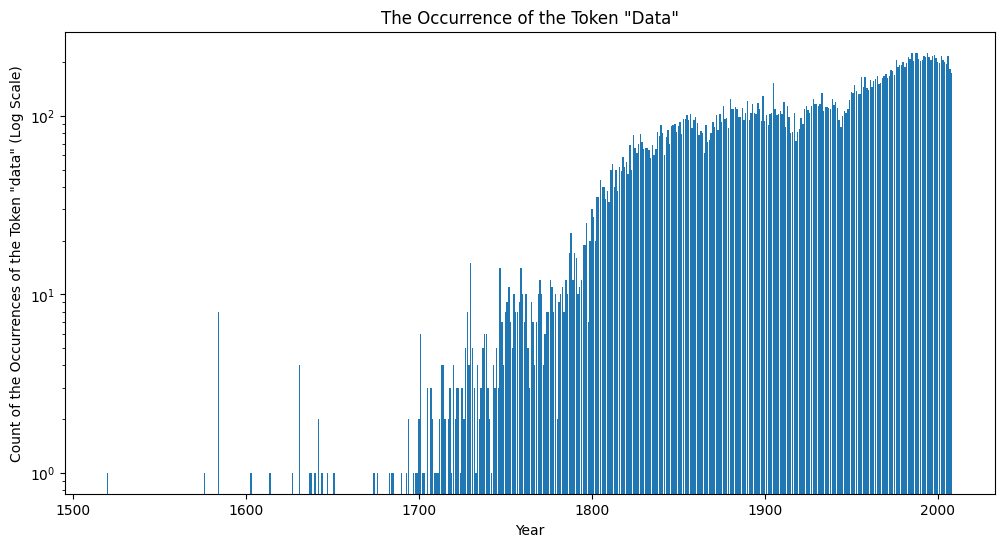

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(plot_eng_df.index, plot_eng_df['frequency'])
# Set the y-axis to a logarithmic scale
plt.yscale('log')
# Adding titles and labels
plt.title('The Occurrence of the Token "Data"')
plt.xlabel('Year')
plt.ylabel('Count of the Occurrences of the Token "data" (Log Scale)')

plt.show()